## Data exploration and baseline model

### Data exploration

In [814]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from torch.utils.data.dataset import random_split

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vectors, build_vocab_from_iterator
from torchtext.vocab import GloVe

In [815]:
# Combined bill text / discriminatory label datasets
df = pd.read_csv("data/ML_text_data.csv")
df

,Unnamed: 0,doc_id,bill_id,text,discriminatory
0,0,2765271,1715368,Enrolled HB 79 LAWS OF ALASKA 2023 ...,0
1,1,2776866,1754951,HB0157a -1- HB 157 New Text Underlined [DE...,0
2,2,2732779,1730487,HB0100a -1- HB 100 New Text Underlined [DE...,0
3,3,2693088,1703596,SB0067A -1- SB 67 New Text Underlined [DEL...,0
4,4,2767132,1751805,SB0119A -1- SB 119 New Text Underlined [DE...,0
...,...,...,...,...,...
2191,51,2783649,1662540,LEGISLATURE OF NEBRASKA ONE HUNDRED EIGHTH LEG...,1
2192,52,151769,264898,As Introduced\n129th General AssemblyRegular S...,1
2193,53,152512,130653,\n\n\n\n\n\nIntroduced Version\n\n\n\n\n\n \n\...,1
2194,54,152513,130653,"\n\n\n\n\n\n\nJanuary 26, 2010\n\n\n\n\n\n\n \...",1


In [816]:
# Drop bills with no text
df = df[df['text'].notna()]
df

,Unnamed: 0,doc_id,bill_id,text,discriminatory
0,0,2765271,1715368,Enrolled HB 79 LAWS OF ALASKA 2023 ...,0
1,1,2776866,1754951,HB0157a -1- HB 157 New Text Underlined [DE...,0
2,2,2732779,1730487,HB0100a -1- HB 100 New Text Underlined [DE...,0
3,3,2693088,1703596,SB0067A -1- SB 67 New Text Underlined [DEL...,0
4,4,2767132,1751805,SB0119A -1- SB 119 New Text Underlined [DE...,0
...,...,...,...,...,...
2191,51,2783649,1662540,LEGISLATURE OF NEBRASKA ONE HUNDRED EIGHTH LEG...,1
2192,52,151769,264898,As Introduced\n129th General AssemblyRegular S...,1
2193,53,152512,130653,\n\n\n\n\n\nIntroduced Version\n\n\n\n\n\n \n\...,1
2194,54,152513,130653,"\n\n\n\n\n\n\nJanuary 26, 2010\n\n\n\n\n\n\n \...",1


In [817]:
# Bill text cleanup function
def clean_text(text):
    text = str(text)
    text = text.replace("\n", " ")
    text = text.replace("New Text Underlined", "")
    text = text.replace("[DELETED TEXT BRACKETED]", "")
    text = re.sub(" {2,}", " ", text)
    text = text.strip().lower().split(" ")
    return text

In [818]:
# Try tokenizing bill texts; identify short/messy texts
tokenized_texts = []
min_len = float('inf')
max_len = 0
lengths = []
num_weird_bills = 0

for text in df["text"]:
    text = clean_text(text)
    tokenized_texts.append(text)
    num_tokens = len(text)
    lengths.append(num_tokens)
    if num_tokens > max_len:
        max_len = num_tokens
    if num_tokens < min_len:
        min_len = num_tokens
    if num_tokens < 100:
        # print short bill texts for inspection
        print(text)
        num_weird_bills += 1

# print key info
print("min length:", min_len, ", max length:", max_len)
print("num bills:", len(tokenized_texts), ", num weird bills:", num_weird_bills)

['sjr2', 'introduced', 'page', '0gyh32c-1', 'by', 'senator', 'waggoner', 'rfd:', 'first', 'read:', '07-mar-gyh32c-1', '03/01/2023', 'pmg', '(l)tgw', '2023-593', 'page', '1sjr___', 'committee', 'appointed', 'to', 'notify', 'governor', 'that', 'the', 'legislature', 'is', 'in', 'session.', 'be', 'it', 'resolved', 'by', 'the', 'legislature', 'of', 'alabama,', 'both', 'houses', 'thereof', 'concurring,', 'that', 'a', 'committee', 'of', 'three', 'members', 'of', 'the', 'senate,', 'to', 'be', 'named', 'by', 'the', 'presiding', 'officer', 'of', 'the', 'senate,', 'and', 'three', 'members', 'of', 'the', 'house,', 'to', 'be', 'named', 'by', 'the', 'speaker', 'of', 'the', 'house,', 'be', 'appointed', 'to', 'notify', 'the', 'governor', 'that', 'the', 'legislature', 'is', 'now', 'in', 'session', 'and', 'is', 'ready', 'for', 'the', 'transaction', 'of', 'business.']
['printed', 'on', 'recycled', 'paper131st', 'maine', 'legislature', 'first', 'regular', 'session-2023', 'legislative', 'document', 'no.', 

<BarContainer object of 20 artists>

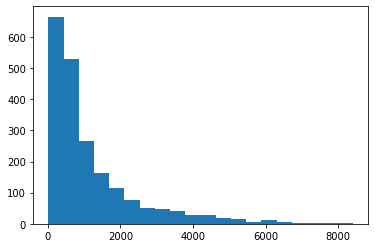

In [819]:
# Get a sense of how many tokens are in most bill texts
_, _, plot = plt.hist(lengths, bins=20)
plot

### Data prep for CBOW model

In [820]:
# Create vocab from bill text
vocab = build_vocab_from_iterator(tokenized_texts, specials=["<unk>"], min_freq = 10)

In [821]:
# Checking the result
print(len(vocab))
print(vocab.lookup_token(0))
print(vocab.lookup_token(15))
print(vocab["bill"])
print(vocab["gender"])
print(vocab["sex"])
print(vocab["transgender"])

12890
<unk>
that
52
219
199
2990


In [822]:
# Turn our labels and cleaned-up text into a coherent dataset (list of tuples)
data = []
for label, tokens in zip(df["discriminatory"], tokenized_texts):
    #single_string = ""
    #for token in text:
    #    single_string = single_string + token + " "
    data.append((label, tokens))

# Iterator version (not sure if needed)
data_iter = iter(data)
[next(data_iter)]

[(0,
  ['enrolled',
   'hb',
   '79',
   'laws',
   'of',
   'alaska',
   '2023',
   'source',
   'chapter',
   'no.',
   'cshb',
   '79(fin)',
   '_______',
   'an',
   'act',
   'making',
   'supplemental',
   'appropriati',
   'ons',
   'and',
   'other',
   'appropriations;',
   'ma',
   'king',
   'appropriations',
   'under',
   'art.',
   'ix,',
   'sec.',
   '17(c),',
   'constitution',
   'of',
   'the',
   'state',
   'of',
   'alaska,',
   'from',
   'the',
   'constitutional',
   'budget',
   'reserve',
   'fund;',
   'and',
   'providing',
   'for',
   'an',
   'effective',
   'date.',
   '_______________',
   'be',
   'it',
   'enacted',
   'by',
   'the',
   'legislature',
   'of',
   'the',
   'state',
   'of',
   'alaska:',
   'the',
   'act',
   'follows',
   'on',
   'page',
   '-1-',
   'enrolled',
   'hb',
   '79',
   'an',
   'act',
   'making',
   'supplemental',
   'appropriati',
   'ons',
   'and',
   'other',
   'appropriations;',
   'ma',
   'king',
   'appro

In [823]:
# Turn our data into custom torch Dataset
    
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.vocab = build_vocab_from_iterator(
            tokenized_texts, specials=["<unk>"], min_freq = 10)
        self.vocab.set_default_index(self.vocab['<unk>'])

    def vocab_size(self):
        # add one more for out of vocab words
        return len(self.vocab) + 1
    
    def get_vocab(self):
        return self.vocab

    def __len__(self):
        return (len(self.data))

    def __getitem__(self, idx):
        label, tokenized_text = self.data[idx]
        #return label, tokenized_texts
        tokenized_texts_idxs = self.vocab.lookup_indices(tokenized_text)
        #print(torch.LongTensor([label]), torch.LongTensor(tokenized_texts_idxs))
        return (torch.LongTensor([label]), torch.LongTensor(tokenized_texts_idxs))    

In [824]:
dataset = CustomDataset(data)

In [825]:
# GloVe
# Change dir!
VECTOR_CACHE_DIR = '/Users/carolynvilter/Documents/MSCAPP_Y2Q3/adv_ml/.vector_cache'
glove = GloVe(name='6B', cache = VECTOR_CACHE_DIR)

In [826]:
# Custom collate function for dataloader
def collate_into_cbow(batch):
    size = len(batch)
    lt = torch.zeros(size,)
    tt = torch.zeros(size, 300)

    for i, (label, token_list) in enumerate(batch):
        # create label tensor
        lt[i] = int(label)

        # create cbow using glove
        all_embeddings = glove.get_vecs_by_tokens([vocab.lookup_token(x) for x in test])
        #all_embeddings = glove.get_vecs_by_tokens(token_list)
        tt[i] = torch.mean(all_embeddings, dim = 0)
    
    lt = lt.type(torch.LongTensor)

    return (lt, tt)

In [827]:
# Create dataloader
dataloader = DataLoader(dataset, batch_size=16, shuffle=False, 
                        collate_fn=collate_into_cbow)

In [828]:
# check dataloader
for idx, (lt, tt) in enumerate(dataloader):
    print(idx, lt.shape, tt.shape)
    if idx == 4: 
        break

0 torch.Size([16]) torch.Size([16, 300])
1 torch.Size([16]) torch.Size([16, 300])
2 torch.Size([16]) torch.Size([16, 300])
3 torch.Size([16]) torch.Size([16, 300])
4 torch.Size([16]) torch.Size([16, 300])


In [829]:
# check dataloader cont.
for idx, (lt, tt) in enumerate(dataloader):
    print(idx, lt, tt)
    if idx == 2: 
        break

0 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) tensor([[-0.0152,  0.0960,  0.1026,  ...,  0.0963, -0.2509,  0.0037],
        [-0.0152,  0.0960,  0.1026,  ...,  0.0963, -0.2509,  0.0037],
        [-0.0152,  0.0960,  0.1026,  ...,  0.0963, -0.2509,  0.0037],
        ...,
        [-0.0152,  0.0960,  0.1026,  ...,  0.0963, -0.2509,  0.0037],
        [-0.0152,  0.0960,  0.1026,  ...,  0.0963, -0.2509,  0.0037],
        [-0.0152,  0.0960,  0.1026,  ...,  0.0963, -0.2509,  0.0037]])
1 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) tensor([[-0.0152,  0.0960,  0.1026,  ...,  0.0963, -0.2509,  0.0037],
        [-0.0152,  0.0960,  0.1026,  ...,  0.0963, -0.2509,  0.0037],
        [-0.0152,  0.0960,  0.1026,  ...,  0.0963, -0.2509,  0.0037],
        ...,
        [-0.0152,  0.0960,  0.1026,  ...,  0.0963, -0.2509,  0.0037],
        [-0.0152,  0.0960,  0.1026,  ...,  0.0963, -0.2509,  0.0037],
        [-0.0152,  0.0960,  0.1026,  ...,  0.0963, -0.2509,  0.0037]])
2 tensor([0, 0

In [830]:
# check dataloader cont.
check = 0
for idx, (lt, tt) in enumerate(dataloader):
    for val in lt:
        if val == 1:
            check += 1
print(check)
print(sum(df["discriminatory"]))

323
323


### CBOW model

In [831]:
# Model class
class CBoWClassifier(nn.Module):
    def __init__(self, num_labels, vocab_size):
        # nn.Module init
        super(CBoWClassifier, self).__init__()
        # linear layer: affine map given input dim, output dim
        self.linear = nn.Linear(vocab_size, num_labels)

    def forward(self, cbow_vec):
        # pass through linear layer, then softmax
        linear_output = self.linear(cbow_vec)
        output = F.log_softmax(linear_output, dim = 1)
        return output

In [832]:
# Training function
import time

loss_function = torch.nn.NLLLoss()

def train_an_epoch(dataloader, optimizer):
    model.train() # Sets the module in training mode.
    log_interval = 20

    for idx, (label, text) in enumerate(dataloader):
        model.zero_grad()
        log_probs = model(text)
        loss = loss_function(log_probs, label)
        loss.backward()
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')

In [833]:
# Accuracy function

def get_accuracy(dataloader):
    model.eval()

    with torch.no_grad():
        total_correct = 0
        total_examples = 0

        for _, (label, text) in enumerate(dataloader):
            output = model(text)
            print("output", output)
            pred_label = output.argmax(1)
            print("pred_label", pred_label)
            if sum(pred_label) > 0:
                print(f"PREDICTED DISCRIMINATORY!")
            num_examples = len(label)
            print("label", label)
            num_correct = sum(torch.eq(pred_label, label))

            total_correct += num_correct
            total_examples += num_examples

    return total_correct/total_examples

In [834]:
# Prep for data split
len_train = int(len(data) * .8)
len_valid = int((len(data) - len_train)/2)
len_test = len(data) - len_train - len_valid
print(len_train, "train", len_valid, "validation", len_test, "testing")

1665 train 208 validation 209 testing


In [835]:
# Set parameters, create model instance, create split dataloaders
BATCH_SIZE = 16

train_data, valid_data, test_data = random_split(
    data, [len_train, len_valid, len_test])

num_labels = len(set([label for (label, text) in train_data]))
vocab_size = len(glove.get_vecs_by_tokens("test"))
model = CBoWClassifier(num_labels, vocab_size)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_into_cbow)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_into_cbow)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_into_cbow)

At iteration 20 the loss is 0.637.
At iteration 40 the loss is 0.615.
At iteration 60 the loss is 0.573.
At iteration 80 the loss is 0.580.
At iteration 100 the loss is 0.570.
output tensor([[-0.5469, -0.8646],
        [-0.5469, -0.8646],
        [-0.5469, -0.8646],
        [-0.5469, -0.8646],
        [-0.5469, -0.8646],
        [-0.5469, -0.8646],
        [-0.5469, -0.8646],
        [-0.5469, -0.8646],
        [-0.5469, -0.8646],
        [-0.5469, -0.8646],
        [-0.5469, -0.8646],
        [-0.5469, -0.8646],
        [-0.5469, -0.8646],
        [-0.5469, -0.8646],
        [-0.5469, -0.8646],
        [-0.5469, -0.8646]])
pred_label tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
label tensor([0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
output tensor([[-0.5469, -0.8646],
        [-0.5469, -0.8646],
        [-0.5469, -0.8646],
        [-0.5469, -0.8646],
        [-0.5469, -0.8646],
        [-0.5469, -0.8646],
        [-0.5469, -0.8646],
        [-0.5469, -0.8646],
      

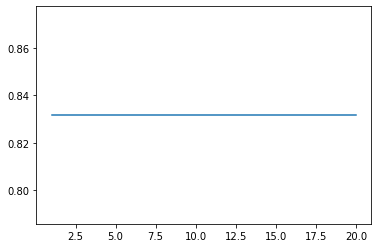

In [836]:
EPOCHS = 20 # epoch
optimizer = torch.optim.SGD(model.parameters(), lr=.0001)

accuracies=[]
for epoch in range(1, EPOCHS + 1):
    train_an_epoch(train_dataloader, optimizer)
    accuracy = get_accuracy(valid_dataloader)
    accuracies.append(accuracy)
    print()
    print(f'After epoch {epoch} the validation accuracy is {accuracy:.3f}.')
    print()
    
plt.plot(range(1, EPOCHS+1), accuracies)

### If you follow the "open in a text editor" link for the above output and ctrl-F for my hopeful print statement "PREDICTED DISCRIMINATORY!" you can double-check whether or not the model literally ever predicted a 1 

In [839]:
# check class 1 ratio as reference point
    # for VALIDATION dataset
# (you'd be right this % of the time if you always guessed non-discriminatory)
total_count = 0
count_1s = 0
for bill in valid_data:
    count_1s += bill[0]
    total_count += 1
1 - count_1s / total_count

0.8317307692307692

### So the model (each time I ran it) is predicting 0 every time, thus the validation accuracy plotted above is a straight line at exactly the true percent of 0s in the validation dataset

In [838]:
get_accuracy(test_dataloader)

output tensor([[-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567]])
pred_label tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
label tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
output tensor([[-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.21

tensor(0.8182)

In [840]:
# check class 1 ratio as reference point
    # for TEST dataset
# (you'd be right this % of the time if you always guessed non-discriminatory)
total_count = 0
count_1s = 0
for bill in test_data:
    count_1s += bill[0]
    total_count += 1
1 - count_1s / total_count

0.8181818181818181

### and same issue with the test data and test accuracy above

### Things to do:
- explore whether there's more initial data cleaning to be done (bill texts are still rough around the edges, a small few are totally messed up)
- produce some simple analytics on the dataset for the final report
- ** research class imbalance (ask TA(s) as well?)
- and the big next step: develop 2 (?) fancier models